In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import PCA
import SimpleITK as sitk

import sys
np.set_printoptions(threshold=sys.maxsize)

## functions

In [2]:
## function definition

# function to convert DESI text file to numpy array
def DESI_txt2numpy(desi_text):
    """""
    input:
    desi_text - the location /name of the DESI text file
    output:
    peaks - 2D numpy array of DESI spectra with size [N_spectra x N_ions]
    mz - 1D numpy array of ions' m/z values [N_ions]
    dim_y - number of spectra in y axis
    dim_x - number of spectra in x axis
    (dim_y * dim_x = N_spectra)
    """""
    ##############################################
    # inner function for getting the number of spectra without buffering vthe data
    def num_lines_in_text(desi_text):

        # inner function for creating the generator
        def _count_generator(reader):
            b = reader(1024 * 1024)
            while b:
                yield b
                b = reader(1024 * 1024)
  
        with open(desi_text, 'rb') as read_obj:
            c_generator = _count_generator(read_obj.raw.read)
            # count each \n
            count = sum(buffer.count(b'\n') for buffer in c_generator)
            """Enters while loop, which continues as long as b (the chunk of data) is not empty. 
            This means that it will keep reading and yielding chunks of data until there's nothing left to read."""

        return count
    ##############################################
    
    print('file:', desi_text)

    total = num_lines_in_text(desi_text)
    print('spectra:', total-5)
    
    data = []
    with open(desi_text, 'r') as read_obj:
        for i,line in tqdm(enumerate(read_obj) , total=total):
            x = line.split()
            y = [float(num) for num in x]
            data.append(y)
            
    ind = np.argsort(data[3]) # data[3] has unsorted m/z values
    mz = np.take_along_axis(np.asarray(data[3]), ind, axis=0) # sort with indices

    x, y = [], []
    peaks = []
    for i in tqdm(range(4,len(data)-1)):
        x.append(data[i][1])
        y.append(data[i][2])
        p = np.asarray(data[i][3:-2])
        p = np.take_along_axis(p, ind, axis=0)
        p = np.expand_dims(p,axis=0)
        peaks.append(p)
    peaks = np.concatenate(peaks,axis=0)

    ## find desi data dimension
    t = np.asarray(x)
    t = np.abs(np.diff(t))
    dim_x = int(np.round(np.max(t)/np.min(t)))+1
    t = np.asarray(y)
    dim_y = int(np.round(np.abs(t[0]-t[-1])/np.max(np.abs(np.diff(t)))))+1
    print('image dimension:',dim_y, 'x', dim_x)
    
    return peaks, mz, dim_y, dim_x

# total ion current normalization (spectrum based)
def tic_normalize(peaks):
    tot_ion_cur = np.sum(peaks, axis=1)
    peaks_ticn = np.empty(peaks.shape)
    for i in range(len(peaks)):
        if tot_ion_cur[i]!=0:
            peaks_ticn[i] = peaks[i]/tot_ion_cur[i]
    return peaks_ticn

# normalize each ion in whole data to have min of 0 and max of 1 (ion based normalization)
def ion_minmax_normalize(peaks):
    max_ion_int = np.max(peaks, axis=0)
    min_ion_int = np.min(peaks, axis=0)
    peaks_ionorm = np.empty(peaks.shape)
    for i in range(peaks.shape[1]):
        if max_ion_int[i]!=min_ion_int[i]:
            peaks_ionorm[:,i] = (peaks[:,i]-min_ion_int[i])/(max_ion_int[i]-min_ion_int[i])
    return peaks_ionorm

In [ ]:
def GetBinnedData(BinSize, Data):
    #https://github.com/McDonnell-Lab/MALDI-UNISA-ML/blob/main/PrepareData_CRC.ipynb
    # Calculate the total number of bins needed to span the range of m/z values
    Overall_min_mzs = np.min(Data)
    Overall_max_mzs = np.max(Data)
    B = int((Overall_max_mzs - Overall_min_mzs) / BinSize) + 1
    
    # Define m/z bin boundaries that are linearly spaced between the minimum and maximum m/z
    BinEdges = np.linspace(Overall_min_mzs, Overall_max_mzs, B)
    
    # Assign each m/z point used to the nearest bin
    Mzs_binning_indices = np.digitize(Data, BinEdges)
    
    # Sum the intensities over each original m/z point assigned to each bin
    Binned_intensities = np.zeros((Data.shape[0], B))
    for i in range(Data.shape[0]):
        for j in range(Data.shape[1]):
            bin_idx = Mzs_binning_indices[i, j] - 1
            Binned_intensities[i, bin_idx] += Data[i, j]
    
    return Binned_intensities

In [ ]:
def logtransform(peaks):
    #https://pubs.acs.org/doi/full/10.1021/acs.analchem.2c00097?casa_token=ns41wFfcqrsAAAAA%3Ax_g4l8NCXWlBJ1EWD3jkxa33J0Z6fcFq85RfkEOP3eKwzgUhqfKXWZLWfn3eemRvhEkqBcDLhP1Qlfc    
    r = np.max(peaks)
    b = 0.01 / (1 - 0.01 * r)

    # log transform each intensity in whole data
    peaks_trans = np.empty(peaks.shape)
    for i in range(peaks.shape[1]):
        peaks_trans[:,i] = b * np.log((1 + peaks[:,i]) / b)
    return peaks_trans

## covert text DESI to numpy array

In [19]:
root_dir = r"C:\Users\jenni\OneDrive - Queen's University\DESI project\DESI TXT colon\DESI TXT colon"

# Create a list to store the required information for each file
file_info_list = []

# Walk through root_dir
for dirpath, dirnames, filenames in os.walk(root_dir):
    # Check if "colon" is in the directory name
    if 'colon' in dirpath:
        # If so, look for .txt files
        for filename in filenames:
            if filename.endswith('.txt'):
                path = os.path.join(dirpath, filename)
                [peaks, mz, dim_y, dim_x] = DESI_txt2numpy(path)
                print(filename)
                print(peaks.shape)
                print(mz.shape)
                print(dim_y, dim_x)
                
                peaks = tic_normalize(peaks)
                peaks_norm = ion_minmax_normalize(peaks)
                print(peaks_norm.shape)
                
                # Remove the .txt extension from the filename
                filename_without_ext = os.path.splitext(filename)[0]
                
                # Save peaks_norm as a np array in the same directory
                np.savetxt(os.path.join(dirpath, f"{filename_without_ext} array.txt"), peaks_norm)
                
                # Add the required information to the list as a dictionary
                file_info_list.append({'filename': filename_without_ext ,'peaks_shape': peaks.shape, 'mz_shape': mz.shape, 'dim_y': dim_y, 'dim_x': dim_x})
                print(file_info_list[-1])




file: C:\Users\jenni\OneDrive - Queen's University\DESI project\DESI TXT colon\DESI TXT colon\2021 03 21 colon 0485699-1 Analyte 1\2021 03 21 colon 0485699-1 Analyte 1.txt
spectra: 44178


  0%|          | 0/44183 [00:00<?, ?it/s]

  0%|          | 0/44178 [00:00<?, ?it/s]

image dimension: 222 x 199
2021 03 21 colon 0485699-1 Analyte 1.txt
(44178, 2000)
(2000,)
222 199
(44178, 2000)
{'filename': '2021 03 21 colon 0485699-1 Analyte 1', 'peaks_shape': (44178, 2000), 'mz_shape': (2000,), 'dim_y': 222, 'dim_x': 199}
file: C:\Users\jenni\OneDrive - Queen's University\DESI project\DESI TXT colon\DESI TXT colon\2021 03 22 colon 0741403-1 Analyte 1\2021 03 22 colon 0741403-1 Analyte 1.txt
spectra: 53823


  0%|          | 0/53828 [00:00<?, ?it/s]

  0%|          | 0/53823 [00:00<?, ?it/s]

image dimension: 231 x 233
2021 03 22 colon 0741403-1 Analyte 1.txt
(53823, 2000)
(2000,)
231 233
(53823, 2000)
{'filename': '2021 03 22 colon 0741403-1 Analyte 1', 'peaks_shape': (53823, 2000), 'mz_shape': (2000,), 'dim_y': 231, 'dim_x': 233}
file: C:\Users\jenni\OneDrive - Queen's University\DESI project\DESI TXT colon\DESI TXT colon\2021 03 22 colon 0962695-1 Analyte 1\2021 03 22 colon 0962695-1 Analyte 1.txt
spectra: 43475


  0%|          | 0/43480 [00:00<?, ?it/s]

  0%|          | 0/43475 [00:00<?, ?it/s]

image dimension: 235 x 185
2021 03 22 colon 0962695-1 Analyte 1.txt
(43475, 2000)
(2000,)
235 185
(43475, 2000)
{'filename': '2021 03 22 colon 0962695-1 Analyte 1', 'peaks_shape': (43475, 2000), 'mz_shape': (2000,), 'dim_y': 235, 'dim_x': 185}
file: C:\Users\jenni\OneDrive - Queen's University\DESI project\DESI TXT colon\DESI TXT colon\2021 03 23 colon 0116468-2 Analyte 1\2021 03 23 colon 0116468-2 Analyte 1.txt
spectra: 51980


  0%|          | 0/51985 [00:00<?, ?it/s]

  0%|          | 0/51980 [00:00<?, ?it/s]

image dimension: 230 x 226
2021 03 23 colon 0116468-2 Analyte 1.txt
(51980, 2000)
(2000,)
230 226
(51980, 2000)
{'filename': '2021 03 23 colon 0116468-2 Analyte 1', 'peaks_shape': (51980, 2000), 'mz_shape': (2000,), 'dim_y': 230, 'dim_x': 226}
file: C:\Users\jenni\OneDrive - Queen's University\DESI project\DESI TXT colon\DESI TXT colon\2021 03 23 colon 1373665-2 Analyte 1\2021 03 23 colon 1373665-2 Analyte 1.txt
spectra: 46920


  0%|          | 0/46925 [00:00<?, ?it/s]

  0%|          | 0/46920 [00:00<?, ?it/s]

image dimension: 204 x 230
2021 03 23 colon 1373665-2 Analyte 1.txt
(46920, 2000)
(2000,)
204 230
(46920, 2000)
{'filename': '2021 03 23 colon 1373665-2 Analyte 1', 'peaks_shape': (46920, 2000), 'mz_shape': (2000,), 'dim_y': 204, 'dim_x': 230}
file: C:\Users\jenni\OneDrive - Queen's University\DESI project\DESI TXT colon\DESI TXT colon\2021 03 29 colon 0122508-2 Analyte 3\2021 03 29 colon 0122508-2 Analyte 3.txt
spectra: 47502


  0%|          | 0/47507 [00:00<?, ?it/s]

  0%|          | 0/47502 [00:00<?, ?it/s]

image dimension: 203 x 234
2021 03 29 colon 0122508-2 Analyte 3.txt
(47502, 2000)
(2000,)
203 234
(47502, 2000)
{'filename': '2021 03 29 colon 0122508-2 Analyte 3', 'peaks_shape': (47502, 2000), 'mz_shape': (2000,), 'dim_y': 203, 'dim_x': 234}
file: C:\Users\jenni\OneDrive - Queen's University\DESI project\DESI TXT colon\DESI TXT colon\2021 03 29 colon 0462641-2 Analyte 2\2021 03 29 colon 0462641-2 Analyte 2.txt
spectra: 50500


  0%|          | 0/50505 [00:00<?, ?it/s]

  0%|          | 0/50500 [00:00<?, ?it/s]

image dimension: 250 x 202
2021 03 29 colon 0462641-2 Analyte 2.txt
(50500, 2000)
(2000,)
250 202
(50500, 2000)
{'filename': '2021 03 29 colon 0462641-2 Analyte 2', 'peaks_shape': (50500, 2000), 'mz_shape': (2000,), 'dim_y': 250, 'dim_x': 202}
file: C:\Users\jenni\OneDrive - Queen's University\DESI project\DESI TXT colon\DESI TXT colon\2021 03 30 colon 0413337-2 Analyte 6\2021 03 30 colon 0413337-2 Analyte 6.txt
spectra: 53915


  0%|          | 0/53920 [00:00<?, ?it/s]

  0%|          | 0/53915 [00:00<?, ?it/s]

image dimension: 205 x 263
2021 03 30 colon 0413337-2 Analyte 6.txt
(53915, 2000)
(2000,)
205 263
(53915, 2000)
{'filename': '2021 03 30 colon 0413337-2 Analyte 6', 'peaks_shape': (53915, 2000), 'mz_shape': (2000,), 'dim_y': 205, 'dim_x': 263}
file: C:\Users\jenni\OneDrive - Queen's University\DESI project\DESI TXT colon\DESI TXT colon\2021 03 30 colon 0720931-3 Analyte 5\2021 03 30 colon 0720931-3 Analyte 5.txt
spectra: 52328


  0%|          | 0/52333 [00:00<?, ?it/s]

  0%|          | 0/52328 [00:00<?, ?it/s]

image dimension: 211 x 248
2021 03 30 colon 0720931-3 Analyte 5.txt
(52328, 2000)
(2000,)
211 248
(52328, 2000)
{'filename': '2021 03 30 colon 0720931-3 Analyte 5', 'peaks_shape': (52328, 2000), 'mz_shape': (2000,), 'dim_y': 211, 'dim_x': 248}
file: C:\Users\jenni\OneDrive - Queen's University\DESI project\DESI TXT colon\DESI TXT colon\2021 03 31 colon 1258561-2 Analyte 7\2021 03 31 colon 1258561-2 Analyte 7.txt
spectra: 45012


  0%|          | 0/45017 [00:00<?, ?it/s]

  0%|          | 0/45012 [00:00<?, ?it/s]

image dimension: 186 x 242
2021 03 31 colon 1258561-2 Analyte 7.txt
(45012, 2000)
(2000,)
186 242
(45012, 2000)
{'filename': '2021 03 31 colon 1258561-2 Analyte 7', 'peaks_shape': (45012, 2000), 'mz_shape': (2000,), 'dim_y': 186, 'dim_x': 242}


In [28]:
for file_info in file_info_list:
    filename = file_info['filename'] + ' array.txt'
    dim_y = file_info['dim_y']
    dim_x = file_info['dim_x']
    output_name = filename.replace("array", "dc-DeepMSI")[:-4]
    print(f"python run.py --input_file \"C:\\Users\\jenni\\OneDrive - Queen's University\\DESI project\\DESI TXT colon\\DESI TXT colon\\{filename}\" --input_shape {dim_y} {dim_x} 2000 --mode spat-contig --output_file \"{output_name}\"")

python run.py --input_file "C:\Users\jenni\OneDrive - Queen's University\DESI project\DESI TXT colon\DESI TXT colon\2021 03 21 colon 0485699-1 Analyte 1 array.txt" --input_shape 222 199 2000 --mode spat-contig --output_file "2021 03 21 colon 0485699-1 Analyte 1 dc-DeepMSI"
python run.py --input_file "C:\Users\jenni\OneDrive - Queen's University\DESI project\DESI TXT colon\DESI TXT colon\2021 03 22 colon 0741403-1 Analyte 1 array.txt" --input_shape 231 233 2000 --mode spat-contig --output_file "2021 03 22 colon 0741403-1 Analyte 1 dc-DeepMSI"
python run.py --input_file "C:\Users\jenni\OneDrive - Queen's University\DESI project\DESI TXT colon\DESI TXT colon\2021 03 22 colon 0962695-1 Analyte 1 array.txt" --input_shape 235 185 2000 --mode spat-contig --output_file "2021 03 22 colon 0962695-1 Analyte 1 dc-DeepMSI"
python run.py --input_file "C:\Users\jenni\OneDrive - Queen's University\DESI project\DESI TXT colon\DESI TXT colon\2021 03 23 colon 0116468-2 Analyte 1 array.txt" --input_shape 

In [3]:
## read files, convert to matlab (or numpy), and save
data_path = r"C:\Users\jenni\Desktop\DESI TXT colon\DESI TXT colon\2021 03 22 colon 0741403-1 Analyte 1\2021 03 22 colon 0741403-1 Analyte 1.txt"
slide_name = r"2021 03 21 colon 0485699.txt"

#file = os.path.join(data_path,slide_name)
[peaks, mz, dim_y, dim_x] = DESI_txt2numpy(data_path)

print(peaks.shape)
print(mz.shape)
print(dim_y, dim_x)

file: C:\Users\jenni\Desktop\DESI TXT colon\DESI TXT colon\2021 03 22 colon 0741403-1 Analyte 1\2021 03 22 colon 0741403-1 Analyte 1.txt
spectra: 53823


  0%|          | 0/53828 [00:00<?, ?it/s]

  0%|          | 0/53823 [00:00<?, ?it/s]

image dimension: 231 x 233
(53823, 2000)
(2000,)
231 233


## preprocessing

In [4]:
peaks = tic_normalize(peaks)
peaks_norm = ion_minmax_normalize(peaks)
print(peaks_norm.shape)

#np.savetxt("2021 03 22 colon 0741403-1 Analyte 1.txt", peaks_norm)


(53823, 2000)


In [ ]:
peaks_log = logtransform(peaks_norm)
print(peaks_log[1:4])
print(peaks_log.shape)

In [ ]:
dz = 0.001
print(max_ion_int, min_ion_int)

peaks_binned = GetBinnedData(dz, peaks_norm)
#print(peaks_binned[1:4])
print(peaks_binned.shape)

In [ ]:
np.savetxt("2021 03 22 colon 0741403-1 log10.txt", peaks_log)

## visualize single spectrum and single ion image

In [ ]:

# reshape peaks to 3D (dim_y x dim_x x N_ions)
peaks_image = peaks.reshape((dim_y,dim_x,-1),order='C')
print(peaks_image.shape)

#visualize a spectrum from a specific (x,y) location
#ind_y = 100
#ind_x = 170
ind_y = dim_y - 1
ind_x = dim_x - 1
plt.figure(figsize=(10,3))
plt.stem(mz, peaks_image[ind_y,ind_x,:], linefmt='k', markerfmt='k', basefmt='k')
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.title('mass spectrum at '+str([ind_y, ind_x]))
plt.show()

# visualize the peak intensity of a specific ion for all spectra
ind_mz = 234
plt.figure(figsize=(8,8))
plt.imshow( peaks_image[:,:,ind_mz], cmap='plasma')
plt.axis('off')
plt.title('m/z = '+str(mz[ind_mz]))
plt.show()


## univariante combined visualization

In [ ]:
# mz[np.argmin(np.abs(mz-277))]

mz_r = 726.539
mz_g = 766.5359
mz_b = 277.0737

# ch_r = np.argwhere(mz==mz_r)
# ch_g = np.argwhere(mz==mz_g)
# ch_b = np.argwhere(mz==mz_b)

ch_r = np.argmin(np.abs(mz-mz_r))
ch_g = np.argmin(np.abs(mz-mz_g))
ch_b = np.argmin(np.abs(mz-mz_b))

image_r = peaks_norm[:,ch_r].reshape((dim_y,dim_x,-1),order='C')
image_g = peaks_norm[:,ch_g].reshape((dim_y,dim_x,-1),order='C')
image_b = peaks_norm[:,ch_b].reshape((dim_y,dim_x,-1),order='C')
image = np.concatenate([image_r,image_g,image_b], axis=2)

int_scale = 2
plt.figure(figsize=(8,8))
plt.imshow(  np.clip(int_scale*image,0,1) , cmap='gray')
plt.show()

## multivaiant visualization

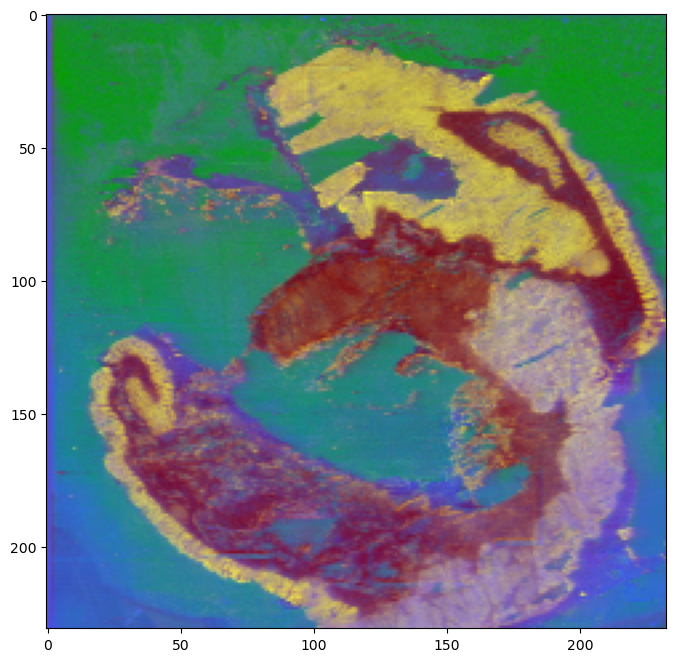

In [5]:
dim_reducion = PCA(n_components=3)

peaks_pca = dim_reducion.fit_transform(peaks_norm)
peaks_pca = ion_minmax_normalize(peaks_pca)
pca_image = peaks_pca.reshape((dim_y,dim_x,-1),order='C')

plt.figure(figsize=(8,8))
plt.imshow(pca_image)
plt.show()

In [8]:
#np.savetxt("2021 03 22 colon 0741403-1 PCA.txt", peaks_pca)
print(pca_image.shape)

(231, 233, 3)


In [ ]:
dim_reduction = PCA(n_components=3)

mask = sitk.ReadImage(r"C:\Users\jenni\OneDrive\Documents\DESI-Sampledata\2021 03 21 colon 0485699_mask.png")
mask_array = sitk.GetArrayFromImage(mask)

mask_reshaped = mask_array[:, :, 0].reshape((222, 199, 1))
print(mask_reshaped[:, :, 0].shape) #testing

peaks_image = peaks_norm.reshape((dim_y,dim_x,-1),order='C') #reshape peaks_norm to (222, 199, 2000)
print(peaks_image.shape) #testing

selected_spectra = peaks_image * mask_reshaped #try index instead to select areas

num_rows, num_cols, num_channels = peaks_image.shape

dim_reduction.fit(peaks_norm)

pca_results = np.zeros((num_rows, num_cols, dim_reduction.n_components))  # Initialize the result array

for i in range(num_rows):
    for j in range(num_cols):
        if mask_reshaped[i, j] == 255:
            # Extract the region of interest (ROI) from the MSI data
            roi = peaks_image[i, j, :].reshape(1, -1)  # Reshape to (1, num_channels)

            # Perform PCA on the ROI using the pre-fitted PCA model
            pca_result = dim_reduction.transform(roi)
            pca_result = ion_minmax_normalize(pca_result)

            # Store the PCA results in the corresponding location in the array
            pca_results[i, j, :] = pca_result

plt.figure(figsize=(8,8))
plt.imshow(pca_results)
plt.show()

In [ ]:
dim_reduction = PCA(n_components=3)

mask = sitk.ReadImage(r"C:\Users\jenni\OneDrive\Documents\DESI-Sampledata\2021 03 21 colon 0485699_mask.png")
mask_array = sitk.GetArrayFromImage(mask)

peaks_image = peaks_norm.reshape((dim_y,dim_x,-1),order='C') #reshape peaks_norm to (222, 199, 2000)
print(peaks_image.shape) #testing

#Get peaks_image shape information
num_rows, num_cols, num_channels = peaks_image.shape


# Step 1: Identify the ROI using the binary mask and create list of ij locations
roi_indices = np.where(mask_array == 255)
roi_pixels = list(zip(roi_indices[0], roi_indices[1]))

# Step 2: Extract spectra from ROI pixels
roi_spectra = []
for i, j in roi_pixels:
    # Extract the spectra for the current ROI pixel (i, j)
    pixel_spectra = peaks_image[i, j]
    roi_spectra.append(pixel_spectra)

# Step 3: convert to np array
roi_spectra_array = np.array(roi_spectra)

# Step 4: Perform PCA

# fit PCA
dim_reduction.fit(roi_spectra_array)

# Perform PCA and normalize
roi_pca = dim_reduction.transform(roi_spectra_array)
roi_pca = ion_minmax_normalize(roi_pca)

# Create empty array and map PCA results from ROI back to the original dimensions (222, 199, 3)
pca_results = np.zeros((num_rows, num_cols, dim_reduction.n_components))
for idx, (i, j) in enumerate(roi_pixels):
    pca_results[i, j, :] = roi_pca[idx]

# # Plot results
# plt.figure(figsize=(8, 8))
# plt.imshow(pca_results)
# plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(pca_results, cmap='viridis')
axes[0].set_title('PCA w/ Mask')

axes[1].imshow(pca_image, cmap='viridis')
axes[1].set_title('PCA Original')

plt.show()


In [ ]:
dim_reducion = PCA(n_components=3)

mask = sitk.ReadImage(r"C:\Users\jenni\OneDrive\Documents\DESI-Sampledata\2021 03 21 colon 0485699_mask.png")
mask_array = sitk.GetArrayFromImage(mask)


mask_reshaped = mask_array[:, :, 0].reshape((222, 199, 1))
print(mask_array[:, :, 0].shape)

peaks_image = peaks_norm.reshape((dim_y,dim_x,-1),order='C') #reshape peaks_norm to (222, 199, 2000)
print(peaks_image.shape) #testing

selected_spectra = peaks_image * mask_reshaped #try index instead to select areas

print(selected_spectra.shape)
#try making a for loop to select pixels that are part of the mask and not, append the ij location of them. New array with PCA results
selected_spectra_image = selected_spectra.reshape(dim_y*dim_x, -1) #Reshape image back to 2D array dim_y*dim_x, -1
print(selected_spectra_image.shape) #testing

peaks_pca = dim_reducion.fit_transform(selected_spectra_image)
peaks_pca = ion_minmax_normalize(peaks_pca)

print(peaks_pca.shape)
pca_image = peaks_pca.reshape((222,199,-1),order='C')
print(pca_image.shape)

plt.figure(figsize=(8,8))
plt.imshow(pca_image)
plt.show()